# Modelo jerárquico final ENSANUT 

In [41]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pytensor  
from patsy import dmatrix, build_design_matrices
from scipy.stats import t as student_t


In [2]:
# read data
df = pd.read_csv("../data/clean/clean2_final_nutricion_salud.csv")

---

## Preprocesamiento

In [3]:
# Filtramos observaciones con datos completos de talla, edad y sexo
df_model = df[["talla_cm", "edad_anios_calc", "sexo", "peso_kg", "municipio", "id_persona"]].dropna()

# Establecemos 'id_persona' como índice del DataFrame
df_model = df_model.set_index("id_persona")

# Codificamos correctamente sexo 
# Recodeamos sexo: 0 = mujer, 1 = hombre
df_model["sexo"] = df_model["sexo"].map({2: 0, 1: 1})

# Confirmamos los tipos de variables y que no haya NAs
df_model.info()
df_model.describe()
df_model["sexo"].value_counts()
df_model["municipio"].nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 25355 entries, 100001_3 to 70336_4
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   talla_cm         25355 non-null  float64
 1   edad_anios_calc  25355 non-null  float64
 2   sexo             25355 non-null  int64  
 3   peso_kg          25355 non-null  float64
 4   municipio        25355 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2+ MB


177

In [4]:
# Codificamos cada municipio con un índice entero único (de 0 a n_grupos - 1)
df_model["municipio_idx"] = pd.Categorical(df_model["municipio"]).codes

# Verificamos que se creó correctamente
df_model[["municipio", "municipio_idx"]].drop_duplicates().sort_values("municipio_idx").head()


,municipio,municipio_idx
id_persona,,
100001_3,1.0,0
11276_3,2.0,1
110044_5,3.0,2
100075_5,4.0,3
100121_6,5.0,4


In [5]:
# Centrar la edad y guardar la media: 
# Esto ayuda a que el intercepto sea interpretable (talla promedio en la edad media) y mejora la estabilidad numérica del muestreo.
edad_mean = df_model["edad_anios_calc"].mean()
df_model["edad_c"] = df_model["edad_anios_calc"] - edad_mean

print(f"Edad media en la muestra: {edad_mean:.3f} años")
df_model[["edad_anios_calc", "edad_c"]].head()


Edad media en la muestra: 6.266 años


,edad_anios_calc,edad_c
id_persona,,
100001_3,8.695414,2.429254
100006_6,11.211499,4.945339
100008_10,7.561944,1.295784
100009_3,6.277892,0.011732
100010_7,8.145106,1.878946


---

## M5: Splines: M4 con splines

In [6]:
# Construcción de B-splines cúbicos para la edad
# (A) Hiperparámetro de flexibilidad
df_spline = 5        # Empezamos con 5; luego probamos 6 o 7 si hace falta.

# (B) Matriz de B-splines cúbicos de la edad (sin intercepto)
X_spline = dmatrix(
    "bs(edad, df=df_spline, degree=3, include_intercept=False) - 1",
    {"edad": df_model["edad_anios_calc"].values},
    return_type="dataframe"
)

# (C) A NumPy para PyMC
X_s = X_spline.to_numpy()

# (D) Chequeo rápido
n_obs, n_s = X_s.shape
print("X_s shape:", X_s.shape)   # (n_obs, n_bases)


X_s shape: (25355, 5)


In [7]:
# Variable objetivo y predictores “clásicos”
y        = df_model["talla_cm"].to_numpy()
sexo     = df_model["sexo"].to_numpy().astype(int)  # 0 = mujer, 1 = hombre

# Edad centrada (importante para estabilidad y para interpretar el intercepto)
edad_c   = (df_model["edad_anios_calc"] - df_model["edad_anios_calc"].mean()).to_numpy()

# Índice entero de municipio por observación (0..n_muni-1)
muni_idx = df_model["municipio_idx"].to_numpy().astype(int)

# Tamaños
n_obs_chk = y.shape[0]
n_muni    = int(muni_idx.max()) + 1

# Chequeos
assert X_s.shape[0] == n_obs_chk, "X_s debe tener tantas filas como observaciones."
print(f"n_obs={n_obs_chk} | n_s(bases)={n_s} | n_muni={n_muni}")


n_obs=25355 | n_s(bases)=5 | n_muni=177


In [ ]:

with pm.Model() as modelo_m5:
    # --- Priors globales (cm) ---
    beta_0        = pm.Normal("beta_0", 125, 10)     # talla a la edad media (sexo=0)
    beta_sexo     = pm.Normal("beta_sexo", 3, 2)     # diferencia nivel hombre vs mujer
    beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2) # interacción lineal edad_c × sexo 

    # --- Pesos de las bases spline (regularización suave) ---
    # Normal(0,1) ≈ “ridge” suave; si vemos curvas muy onduladas, bajamos a 0.5
    w_s = pm.Normal("w_s", 0, 1.0, shape=n_s)

    # --- Efectos aleatorios por municipio (no-centrados) ---
    sd_a0 = pm.HalfNormal("sd_a0", 5)   # desviación estándar de interceptos municipales (cm)
    sd_a1 = pm.HalfNormal("sd_a1", 2)   # desviación estándar de pendientes municipales (cm/año)
    
    z_a0 = pm.Normal("z_a0", 0, 1, shape=n_muni)  # efectos latentes estándar (interceptos)
    z_a1 = pm.Normal("z_a1", 0, 1, shape=n_muni)  # efectos latentes estándar (pendientes)
    
    a0 = pm.Deterministic("a0", sd_a0 * z_a0)  # interceptos municipales (no-centrado)
    a1 = pm.Deterministic("a1", sd_a1 * z_a1)  # pendientes municipales (no-centrado)


    # --- Curva de edad a partir de las bases ---
    # dot(X_s, w_s): vector (n_obs,) con la contribución no lineal de la edad
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s, w_s))

    # --- Media (predicción) ---
    mu = (
        beta_0
        + beta_sexo * sexo
        + f_edad                        # curva suave común por edad
        + a0[muni_idx]                  # nivel municipal
        + a1[muni_idx] * edad_c         # “tilt” lineal municipal
        + beta_edad_sex * (edad_c * sexo)  # diferencia de pendiente global por sexo
    )

    # --- Likelihood robusta ---
    nu    = pm.Exponential("nu", 1/10)     # g.l. (media 10)
    sigma = pm.HalfNormal("sigma_obs", 5)  # escala residual (cm)
    talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y)


Por qué “no centrado” en a0, a1:

Cuando la variación entre municipios (sd_a*) es pequeña o el muestreo está “tenso”, la forma no centrada (z ~ N(0,1); a = sd*z) mejora mucho la mezcla y reduce divergencias.

In [9]:
with modelo_m5:
    idata_m5 = pm.sample(
        draws=1000, tune=1000,          # empezamos moderado; si todo OK luego subimos a 1200–1500
        chains=4, cores=1,            # cores=1 evita issues en notebooks/entornos limitados
        target_accept=0.97,           # alto = menos divergences (si hay, subimos a 0.99)
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

    # PPC (para plot_ppc y checks)
    ppc_m5 = pm.sample_posterior_predictive(idata_m5, return_inferencedata=True, random_seed=42)
    idata_m5.extend(ppc_m5)   # <- sin reasignar

    print(idata_m5.groups())


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, beta_sexo, beta_edad_sex, w_s, sd_a0, sd_a1, z_a0, z_a1, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8864 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

['posterior', 'posterior_predictive', 'log_likelihood', 'sample_stats', 'observed_data']


In [10]:
summ = az.summary(idata_m5, round_to=2)
display(summ.head(12))

/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,106.29,0.38,105.57,106.98,0.01,0.01,1062.07,1766.21,1.00
beta_sexo,0.48,0.07,0.36,0.61,0.00,0.00,6941.20,3220.83,1.00
beta_edad_sex,-0.24,0.02,-0.28,-0.20,0.00,0.00,7198.10,2839.70,1.00
w_s[0],10.42,0.36,9.76,11.11,0.01,0.01,3697.20,2967.67,1.00
w_s[1],10.58,0.30,10.00,11.13,0.01,0.00,1739.15,2898.88,1.00
w_s[2],3.95,0.50,3.02,4.88,0.01,0.01,1378.66,2417.37,1.00
w_s[3],-1.13,0.62,-2.33,0.01,0.02,0.01,1421.18,2399.10,1.00
w_s[4],-4.53,0.67,-5.76,-3.25,0.02,0.01,1404.64,2029.01,1.00
z_a0[0],0.75,0.14,0.50,1.01,0.00,0.00,757.12,1984.11,1.01
z_a0[1],0.51,0.14,0.26,0.78,0.00,0.00,899.73,1877.99,1.00


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/2900665297.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)  # (n_obs, 2)


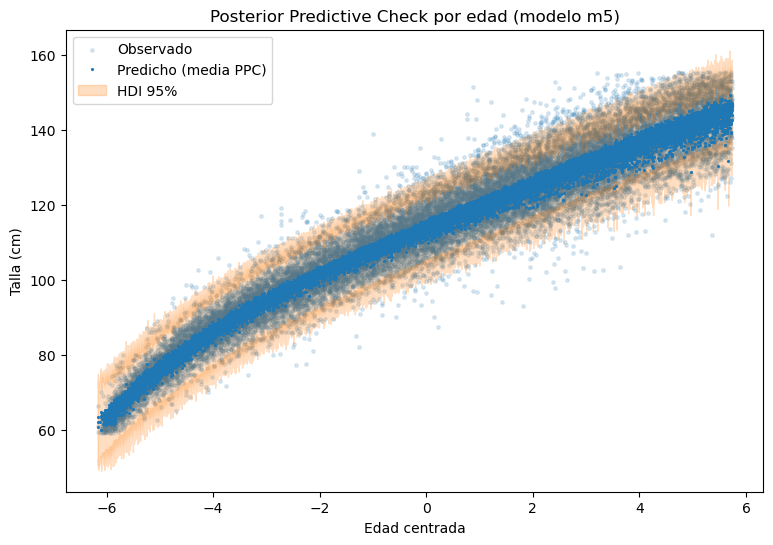

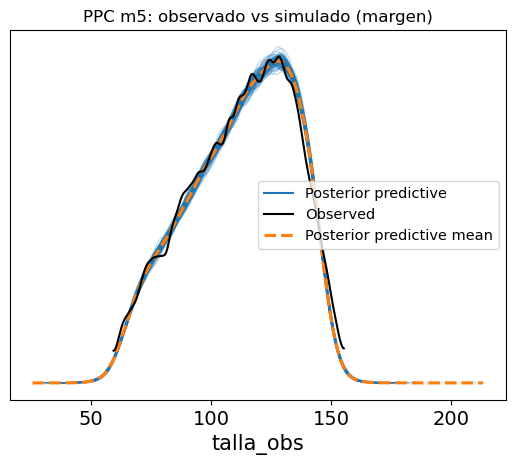

In [ ]:

# === Extraer simulaciones PPC ===
y_ppc = idata_m5.posterior_predictive["talla_obs"].stack(sample=("chain","draw")).values.T  
# shape: (n_samples, n_obs)

# === Calcular media y bandas de credibilidad por observación ===
y_ppc_mean = y_ppc.mean(axis=0)
y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)  # (n_obs, 2)

# === Ordenar por edad centrada ===
ord = np.argsort(edad_c)

# === Graficar ===
plt.figure(figsize=(9,6))
plt.scatter(edad_c, y, s=6, alpha=0.15, label="Observado")
plt.plot(edad_c[ord], y_ppc_mean[ord], ".", ms=2.5, label="Predicho (media PPC)")

# Banda de credibilidad
plt.fill_between(
    edad_c[ord],
    y_ppc_hdi[:,0][ord],
    y_ppc_hdi[:,1][ord],
    color="C1", alpha=0.25, label="HDI 95%"
)

plt.xlabel("Edad centrada")
plt.ylabel("Talla (cm)")
plt.title("Posterior Predictive Check por edad (modelo m5)")
plt.legend()
plt.show()

# === PPC margen: observado vs simulado ===

az.plot_ppc(
    idata_m5,
    var_names=["talla_obs"],   # <- aquí indicas la variable observada/simulada
    num_pp_samples=100,        # número de simulaciones a mostrar
    kind="kde",                # densidad suave
    alpha=0.3
)

plt.title("PPC m5: observado vs simulado (margen)")
plt.show()




---

## M5a: Ligeras mejoras al M5: priors más acotados 

Menos varianza entre municipios, menor riesgo de sobreajuste; posible pequeño aumento de sesgo.

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, beta_sexo, beta_edad_sex, w_s, sd_a0, sd_a1, z_a0, z_a1, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40980 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

                  mean     sd   hdi_3%  hdi_97%
beta_0         106.242  0.365  105.558  106.939
beta_sexo        0.479  0.066    0.359    0.609
beta_edad_sex   -0.235  0.020   -0.273   -0.198
sd_a0            1.509  0.115    1.310    1.730
sd_a1            6.700  0.288    6.209    7.286
...                ...    ...      ...      ...
z_a1[172]        1.051  0.058    0.947    1.166
z_a1[173]        1.174  0.084    1.017    1.337
z_a1[174]        1.134  0.094    0.953    1.304
z_a1[175]        1.143  0.066    1.022    1.271
z_a1[176]        1.181  0.076    1.039    1.323

[359 rows x 4 columns]


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/1876634105.py:78: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)


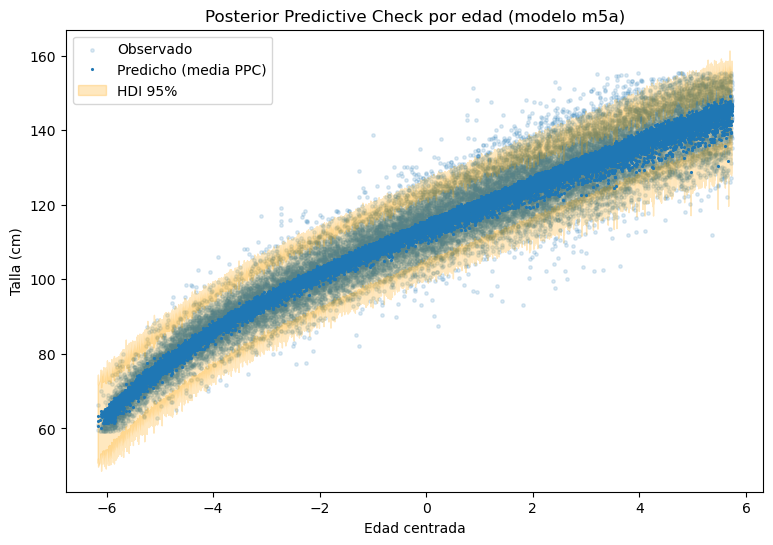

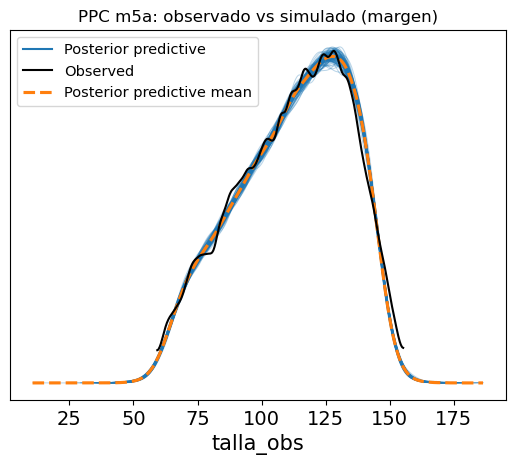

In [14]:
# ==============================
# Modelo jerárquico bayesiano (m5a)
# ==============================
with pm.Model() as modelo_m5a:
    # --- Priors globales (cm) ---
    beta_0        = pm.Normal("beta_0", 125, 10)     # talla a edad media (sexo=0)
    beta_sexo     = pm.Normal("beta_sexo", 3, 2)     # diferencia nivel hombre vs mujer
    beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2) # interacción lineal edad_c × sexo (opcional)

    # --- Pesos de las bases spline (regularización suave) ---
    w_s = pm.Normal("w_s", 0, 1.0, shape=n_s)

    # --- Efectos aleatorios por municipio (no-centrados) ---
    sd_a0 = pm.HalfNormal("sd_a0", 2.5)   # sd de interceptos municipales (cm)
    sd_a1 = pm.HalfNormal("sd_a1", 1.0)   # sd de pendientes municipales (cm/año)

    z_a0 = pm.Normal("z_a0", 0, 1, shape=n_muni)
    z_a1 = pm.Normal("z_a1", 0, 1, shape=n_muni)

    a0   = pm.Deterministic("a0", sd_a0 * z_a0) 
    a1   = pm.Deterministic("a1", sd_a1 * z_a1)

    # --- Curva de edad a partir de las bases ---
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s, w_s))

    # --- Media (predicción) ---
    mu = (
        beta_0
        + beta_sexo * sexo
        + f_edad
        + a0[muni_idx]
        + a1[muni_idx] * edad_c
        + beta_edad_sex * (edad_c * sexo)
    )

    # --- Likelihood robusta ---
    nu    = pm.Exponential("nu", 1/10)     
    sigma = pm.HalfNormal("sigma_obs", 5)  
    talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y)

    # ==============================
    # Muestreo
    # ==============================
    idata_m5a = pm.sample(
        draws=2000, tune=2000,
        chains=4, cores=1,
        target_accept=0.99,
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

    # ==============================
    # PPC
    # ==============================
    ppc_m5a = pm.sample_posterior_predictive(
        idata_m5a, return_inferencedata=True, random_seed=42
    )
    idata_m5a.extend(ppc_m5a)


# ==============================
# Resumen diagnóstico
# ==============================
print(az.summary(
    idata_m5a, 
    var_names=["beta_0","beta_sexo","beta_edad_sex","sd_a0","sd_a1","z_a0","z_a1"],
    kind="stats"
))


# ==============================
# PPC por edad
# ==============================
y_ppc = idata_m5a.posterior_predictive["talla_obs"].stack(sample=("chain","draw")).values.T
y_ppc_mean = y_ppc.mean(axis=0)
y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)

ord = np.argsort(edad_c)

plt.figure(figsize=(9,6))
plt.scatter(edad_c, y, s=6, alpha=0.15, label="Observado")
plt.plot(edad_c[ord], y_ppc_mean[ord], ".", ms=2.5, label="Predicho (media PPC)")
plt.fill_between(
    edad_c[ord],
    y_ppc_hdi[:,0][ord],
    y_ppc_hdi[:,1][ord],
    color="orange", alpha=0.25, label="HDI 95%"
)
plt.xlabel("Edad centrada")
plt.ylabel("Talla (cm)")
plt.title("Posterior Predictive Check por edad (modelo m5a)")
plt.legend()
plt.show()


# ==============================
# PPC marginal
# ==============================
az.plot_ppc(
    idata_m5a,
    var_names=["talla_obs"],
    num_pp_samples=100,
    kind="kde",
    alpha=0.3
)
plt.title("PPC m5a: observado vs simulado (margen)")
plt.show()


In [16]:
az.summary(idata_m5a, round_to=2)
display(summ.head(12))

/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,106.29,0.38,105.57,106.98,0.01,0.01,1062.07,1766.21,1.00
beta_sexo,0.48,0.07,0.36,0.61,0.00,0.00,6941.20,3220.83,1.00
beta_edad_sex,-0.24,0.02,-0.28,-0.20,0.00,0.00,7198.10,2839.70,1.00
w_s[0],10.42,0.36,9.76,11.11,0.01,0.01,3697.20,2967.67,1.00
w_s[1],10.58,0.30,10.00,11.13,0.01,0.00,1739.15,2898.88,1.00
w_s[2],3.95,0.50,3.02,4.88,0.01,0.01,1378.66,2417.37,1.00
w_s[3],-1.13,0.62,-2.33,0.01,0.02,0.01,1421.18,2399.10,1.00
w_s[4],-4.53,0.67,-5.76,-3.25,0.02,0.01,1404.64,2029.01,1.00
z_a0[0],0.75,0.14,0.50,1.01,0.00,0.00,757.12,1984.11,1.01
z_a0[1],0.51,0.14,0.26,0.78,0.00,0.00,899.73,1877.99,1.00


In [19]:
pd.set_option("display.max_rows", None)    # sin límite de filas
pd.set_option("display.max_columns", None) # sin límite de columnas
pd.set_option("display.width", None)       # ajuste de ancho automático

summary_m5a = az.summary(
    idata_m5a, 
    var_names=["beta_0","beta_sexo","beta_edad_sex","sd_a0","sd_a1","z_a0","z_a1"],
    kind="stats"
)
print(summary_m5a)



                  mean     sd   hdi_3%  hdi_97%
beta_0         106.242  0.365  105.558  106.939
beta_sexo        0.479  0.066    0.359    0.609
beta_edad_sex   -0.235  0.020   -0.273   -0.198
sd_a0            1.509  0.115    1.310    1.730
sd_a1            6.700  0.288    6.209    7.286
z_a0[0]          0.756  0.138    0.495    1.011
z_a0[1]          0.520  0.135    0.265    0.778
z_a0[2]          0.765  0.160    0.479    1.083
z_a0[3]          0.500  0.138    0.253    0.769
z_a0[4]          1.022  0.157    0.723    1.310
z_a0[5]          0.499  0.160    0.204    0.805
z_a0[6]          0.914  0.174    0.580    1.232
z_a0[7]          1.024  0.166    0.712    1.327
z_a0[8]          0.613  0.173    0.293    0.941
z_a0[9]          0.880  0.168    0.564    1.190
z_a0[10]         1.192  0.201    0.794    1.549
z_a0[11]         0.611  0.173    0.293    0.945
z_a0[12]         0.396  0.218    0.002    0.819
z_a0[13]         0.749  0.179    0.414    1.082
z_a0[14]         0.809  0.216    0.402  

In [35]:
def ppc_municipios(
    idata, 
    y, 
    edad,                      # np.ndarray 1D
    muni_idx, 
    munis=None, 
    n_random=6, 
    hdi_prob=0.95, 
    seed=42,
    titulo="PPC por municipio (m5a)"
):
    import numpy as np
    import arviz as az
    import matplotlib.pyplot as plt

    edad = np.asarray(edad); y = np.asarray(y); muni_idx = np.asarray(muni_idx)
    if not (edad.ndim == y.ndim == muni_idx.ndim == 1 and len(edad) == len(y) == len(muni_idx)):
        raise ValueError("edad, y y muni_idx deben ser vectores 1D de igual longitud.")

    rng = np.random.default_rng(seed)
    uniq = np.unique(muni_idx)
    if munis is None:
        munis = rng.choice(uniq, size=min(n_random, len(uniq)), replace=False)
    else:
        munis = np.array([m for m in np.asarray(munis) if m in uniq])
        if munis.size == 0:
            raise ValueError("Ninguno de los municipios especificados existe en muni_idx.")

    # --- PPC: (sample, obs) sin asumir nombres de dims ---
    da = idata.posterior_predictive["talla_obs"].stack(sample=("chain", "draw"))
    obs_dim = next(d for d in da.dims if d != "sample")
    y_ppc = da.transpose("sample", obs_dim).values  # (n_samples, n_obs)

    r = int(np.ceil(len(munis) / 3)); c = min(3, len(munis))
    fig, axes = plt.subplots(r, c, figsize=(5.5 * c, 4 * r), squeeze=False)

    legend_set = False
    for ax, m in zip(axes.ravel(), munis):
        mask = (muni_idx == m)
        n_m = int(mask.sum())
        if n_m == 0:
            ax.axis("off"); continue

        edad_m = edad[mask]; y_m = y[mask]
        y_ppc_m = y_ppc[:, mask]  # (n_samples, n_m)

        mean_ppc = y_ppc_m.mean(axis=0)                 # (n_m,)
        hdi_m    = az.hdi(y_ppc_m, hdi_prob=hdi_prob)   # (n_m, 2), axis=0 por defecto

        ordm = np.argsort(edad_m)
        ax.scatter(edad_m, y_m, s=8, alpha=0.3, label="Obs")
        ax.plot(edad_m[ordm], mean_ppc[ordm], ".", ms=3, label="Media PPC")
        ax.fill_between(edad_m[ordm], hdi_m[ordm, 0], hdi_m[ordm, 1],
                        color="orange", alpha=0.3, label=f"HDI {int(hdi_prob*100)}%")
        ax.set_title(f"Municipio {int(m)}  (n={n_m})")
        ax.grid(alpha=0.2)

        if not legend_set:
            handles, labels = ax.get_legend_handles_labels()
            if handles:
                fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
                legend_set = True

    fig.suptitle(titulo, y=1.02, fontsize=13)
    fig.tight_layout()
    plt.show()


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/25132345.py:48: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_m    = az.hdi(y_ppc_m, hdi_prob=hdi_prob)   # (n_m, 2), axis=0 por defecto
/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/25132345.py:48: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_m    = az.hdi(y_ppc_m, hdi_prob=hdi_prob)   # (n_m, 2), axis=0 por defecto
/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/25132345.py:48: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_m    = az.hdi(y_ppc_m, hdi_prob=hdi_prob)   # (n_m, 2), axis=0 por defecto
/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw000

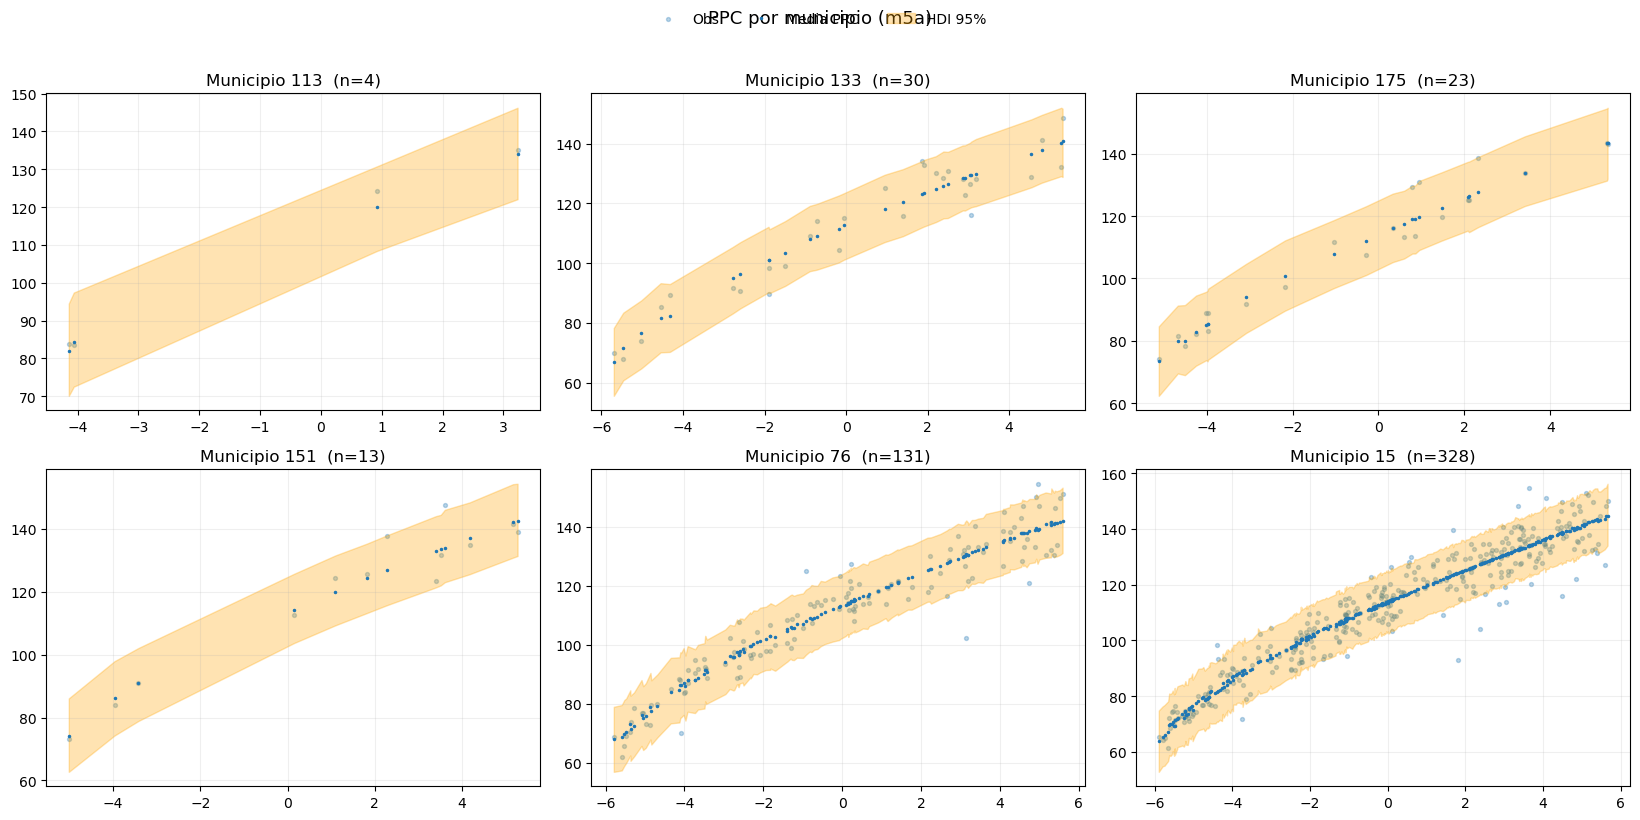

In [36]:
# Aleatorios (6 por defecto)
ppc_municipios(idata_m5a, y, edad_c, muni_idx, munis=None, n_random=6, titulo="PPC por municipio (m5a)")

# Específicos
# ppc_municipios(idata_m5a, y, edad_c, muni_idx, munis=[0,5,12,20,37,58], titulo="PPC por municipio (m5a)")


---

## M5b: imponiendo suma cero 

Intento: En m5a los z_a1 se concentraban ~1, y que al imponer suma-cero + estandarizar edad, en m5b los z_a1 se recentran en 0 y sd_a1 queda interpretable (cm por 1 DE de edad).

In [ ]:

# # 1) estandarizar edad centrada
# edad_z = (edad_c - np.mean(edad_c)) / np.std(edad_c)

# with pm.Model() as modelo_m5b:
#     # Priors globales
#     beta_0        = pm.Normal("beta_0", 125, 10)
#     beta_sexo     = pm.Normal("beta_sexo", 3, 2)
#     beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2)

#     # Spline global
#     w_s   = pm.Normal("w_s", 0, 1.0, shape=n_s)
#     f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s, w_s))

#     # Efectos aleatorios (no centrados)
#     sd_a0 = pm.HalfNormal("sd_a0", 2.5)
#     sd_a1 = pm.HalfNormal("sd_a1", 1.0)

#     z_a0  = pm.Normal("z_a0", 0, 1, shape=n_muni)

#     # --- suma-cero en pendientes municipales ---
#     z_a1_raw = pm.Normal("z_a1_raw", 0, 1, shape=n_muni)
#     z_a1     = pm.Deterministic("z_a1", z_a1_raw - pm.math.mean(z_a1_raw))

#     a0 = pm.Deterministic("a0", sd_a0 * z_a0)
#     a1 = pm.Deterministic("a1", sd_a1 * z_a1)

#     # Media
#     mu = (
#         beta_0
#         + beta_sexo * sexo
#         + f_edad
#         + a0[muni_idx]
#         + a1[muni_idx] * edad_z         # usa edad estandarizada
#         + beta_edad_sex * (edad_z * sexo)
#     )

#     # Likelihood robusta
#     nu    = pm.Exponential("nu", 1/10)
#     sigma = pm.HalfNormal("sigma_obs", 5)
#     talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y)

#     # Muestreo
#     idata_m5b = pm.sample(
#         draws=2000, tune=2000,
#         chains=4, cores=1,
#         target_accept=0.99,
#         init="jitter+adapt_diag",
#         random_seed=42,
#         return_inferencedata=True,
#         idata_kwargs={"log_likelihood": True}
#     )

#     # PPC
#     ppc_m5b = pm.sample_posterior_predictive(idata_m5b, return_inferencedata=True, random_seed=42)
#     idata_m5b.extend(ppc_m5b)

# # Diagnóstico rápido (z_a1 debe recentrarse ≈ 0)
# print(az.summary(idata_m5b, var_names=["sd_a0","sd_a1","z_a1","a1"], kind="stats").head(12))


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, beta_sexo, beta_edad_sex, w_s, sd_a0, sd_a1, z_a0, z_a1_raw, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69658 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           mean     sd  hdi_3%  hdi_97%
sd_a0     1.518  0.113   1.303    1.726
sd_a1    35.261  0.520  34.261   36.223
z_a1[0]   0.635  0.010   0.616    0.654
z_a1[1]   0.627  0.010   0.607    0.645
z_a1[2]   0.638  0.011   0.618    0.658
z_a1[3]   0.634  0.010   0.615    0.653
z_a1[4]   0.640  0.011   0.619    0.659
z_a1[5]   0.637  0.011   0.617    0.657
z_a1[6]   0.638  0.011   0.618    0.659
z_a1[7]   0.630  0.010   0.610    0.650
z_a1[8]   0.645  0.011   0.625    0.666
z_a1[9]   0.647  0.011   0.626    0.667


In [ ]:
# az.summary(idata_m5b, round_to=2)
# display(summ.head(12))

/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,106.29,0.38,105.57,106.98,0.01,0.01,1062.07,1766.21,1.00
beta_sexo,0.48,0.07,0.36,0.61,0.00,0.00,6941.20,3220.83,1.00
beta_edad_sex,-0.24,0.02,-0.28,-0.20,0.00,0.00,7198.10,2839.70,1.00
w_s[0],10.42,0.36,9.76,11.11,0.01,0.01,3697.20,2967.67,1.00
w_s[1],10.58,0.30,10.00,11.13,0.01,0.00,1739.15,2898.88,1.00
w_s[2],3.95,0.50,3.02,4.88,0.01,0.01,1378.66,2417.37,1.00
w_s[3],-1.13,0.62,-2.33,0.01,0.02,0.01,1421.18,2399.10,1.00
w_s[4],-4.53,0.67,-5.76,-3.25,0.02,0.01,1404.64,2029.01,1.00
z_a0[0],0.75,0.14,0.50,1.01,0.00,0.00,757.12,1984.11,1.01
z_a0[1],0.51,0.14,0.26,0.78,0.00,0.00,899.73,1877.99,1.00


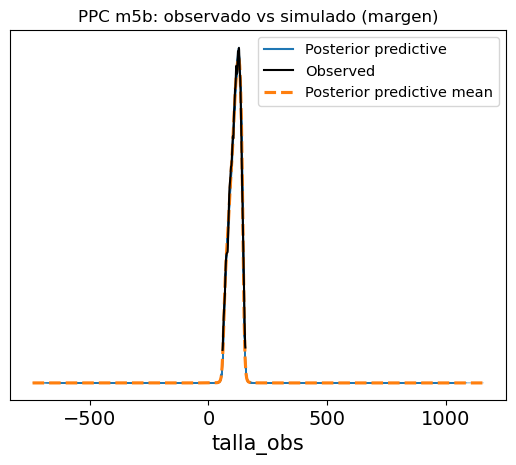

/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/2578807934.py:20: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)


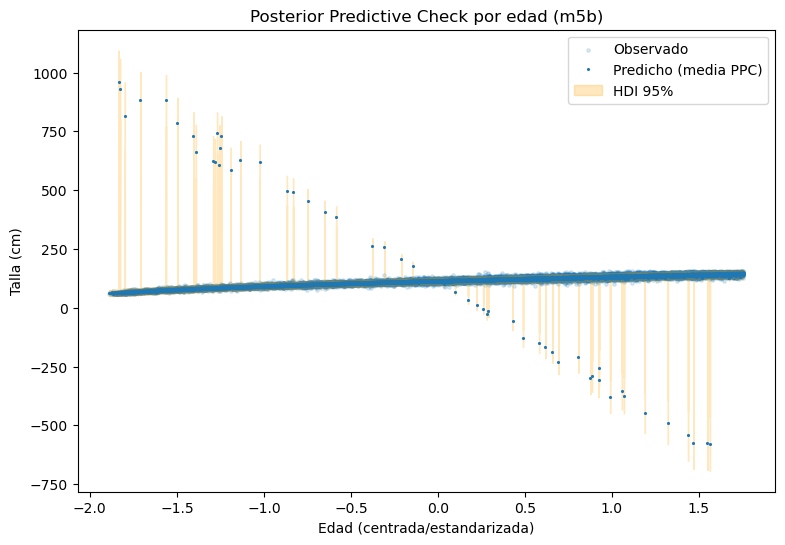

In [ ]:

# try:
#     edad_b = edad_z
# except NameError:
#     edad_b = edad_c  # si no estandarizaste

# # --- PPC marginal ---
# az.plot_ppc(
#     idata_m5b,
#     var_names=["talla_obs"],
#     num_pp_samples=100,
#     kind="kde",
#     alpha=0.3
# )
# plt.title("PPC m5b: observado vs simulado (margen)")
# plt.show()

# # --- PPC por edad (media + banda HDI) ---
# y_ppc = idata_m5b.posterior_predictive["talla_obs"].stack(sample=("chain","draw")).values.T
# y_ppc_mean = y_ppc.mean(axis=0)
# y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)

# ord_ = np.argsort(edad_b)
# plt.figure(figsize=(9,6))
# plt.scatter(edad_b, y, s=6, alpha=0.15, label="Observado")
# plt.plot(edad_b[ord_], y_ppc_mean[ord_], ".", ms=2.5, label="Predicho (media PPC)")
# plt.fill_between(edad_b[ord_], y_ppc_hdi[:,0][ord_], y_ppc_hdi[:,1][ord_],
#                  color="orange", alpha=0.25, label="HDI 95%")
# plt.xlabel("Edad (centrada/estandarizada)"); plt.ylabel("Talla (cm)")
# plt.title("Posterior Predictive Check por edad (m5b)")
# plt.legend(); plt.show()


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/3450830390.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_ppc_m, hdi_prob=hdi_prob)
/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/3450830390.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_ppc_m, hdi_prob=hdi_prob)
/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/3450830390.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_ppc_m, hdi_prob=hdi_prob)
/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/3450830390.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but 

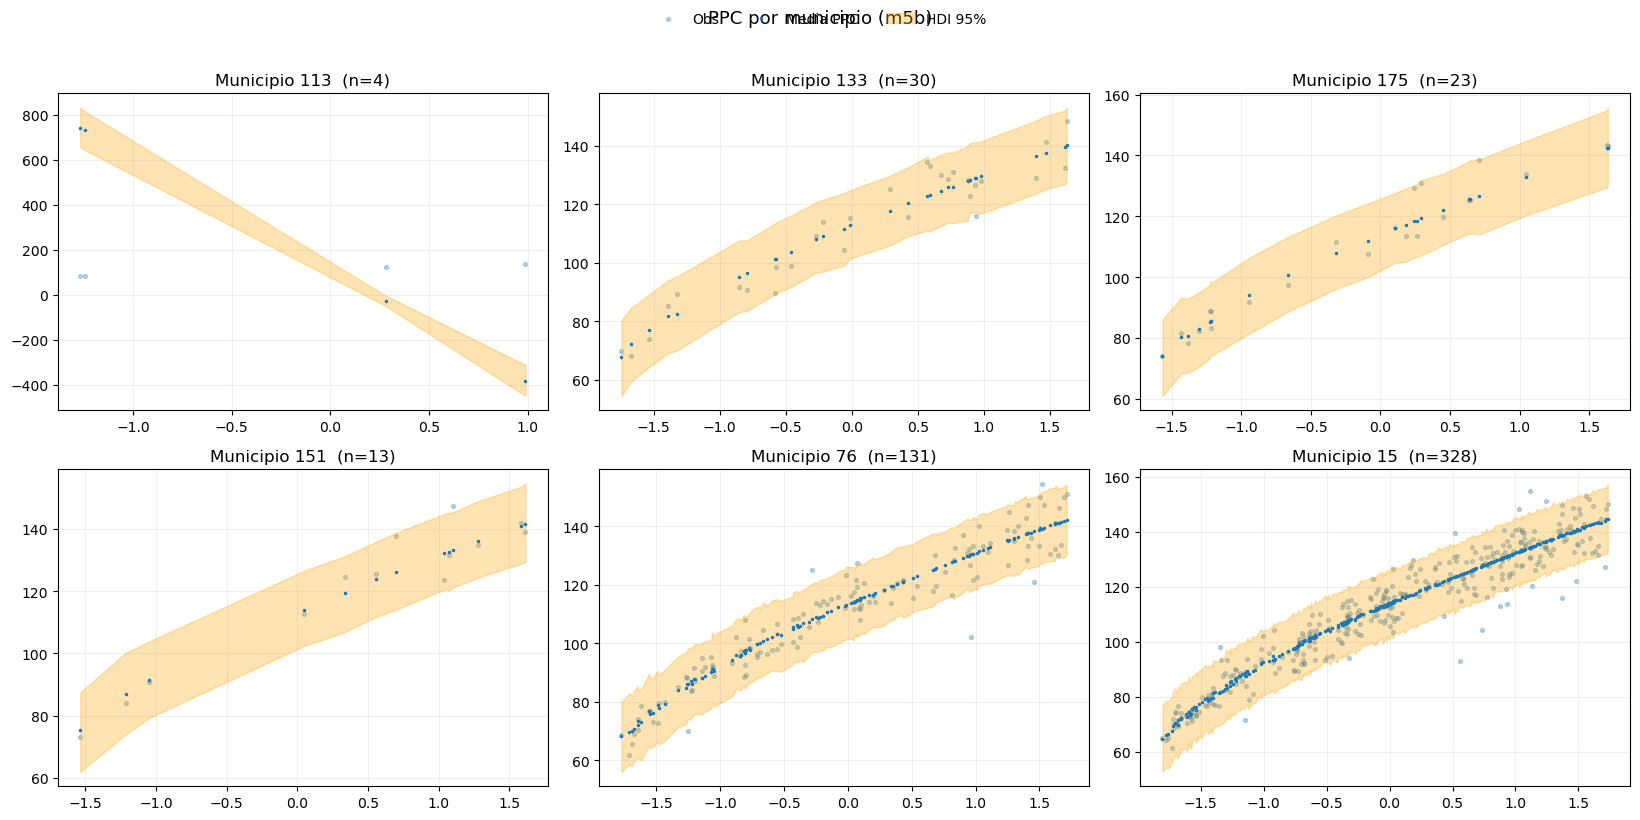

In [ ]:
# # Función para graficar PPC por municipios específicos o aleatorios
# def ppc_municipios(idata, y, edad, muni_idx, munis=None, n_random=6, hdi_prob=0.95, seed=42):
#     rng = np.random.default_rng(seed)
#     if munis is None:
#         uniq = np.unique(muni_idx)
#         munis = rng.choice(uniq, size=min(n_random, len(uniq)), replace=False)

#     y_ppc = idata.posterior_predictive["talla_obs"].stack(sample=("chain","draw")).values.T
#     r = int(np.ceil(len(munis)/3))
#     c = min(3, len(munis))
#     fig, axes = plt.subplots(r, c, figsize=(5.5*c, 4*r), squeeze=False)

#     for ax, m in zip(axes.ravel(), munis):
#         mask = (muni_idx == m)
#         if mask.sum() == 0:
#             ax.axis("off"); continue
#         edad_m, y_m = edad[mask], y[mask]
#         y_ppc_m = y_ppc[:, mask]
#         mean_ppc = y_ppc_m.mean(axis=0)
#         hdi = az.hdi(y_ppc_m, hdi_prob=hdi_prob)
#         ordm = np.argsort(edad_m)
#         ax.scatter(edad_m, y_m, s=8, alpha=0.3, label="Obs")
#         ax.plot(edad_m[ordm], mean_ppc[ordm], ".", ms=3, label="Media PPC")
#         ax.fill_between(edad_m[ordm], hdi[:,0][ordm], hdi[:,1][ordm],
#                         color="orange", alpha=0.3, label=f"HDI {int(hdi_prob*100)}%")
#         ax.set_title(f"Municipio {int(m)}  (n={mask.sum()})")
#         ax.grid(alpha=0.2)

#     # leyenda única
#     handles, labels = axes[0,0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
#     fig.suptitle("PPC por municipio (m5b)", y=1.02, fontsize=13)
#     fig.tight_layout(); plt.show()

# # a) Aleatorios (6 por defecto)
# ppc_municipios(idata_m5b, y, edad_b, muni_idx, munis=None, n_random=6)

# # b) Específicos (ejemplo: cambia la lista por los que quieras ver)
# # ppc_municipios(idata_m5b, y, edad_b, muni_idx, munis=[0,5,12,20,37,58])


In [ ]:

# # Cobertura HDI 95%
# y_ppc = idata_m5b.posterior_predictive["talla_obs"].stack(sample=("chain","draw")).values.T
# hdi95  = az.hdi(y_ppc, hdi_prob=0.95)            # (n_obs, 2)
# coverage = np.mean((y >= hdi95[:,0]) & (y <= hdi95[:,1]))
# print(f"Cobertura HDI 95%: {coverage:.3f}")

# # LOO (resumen)
# loo_m5b = az.loo(idata_m5b, pointwise=False)
# print(loo_m5b)


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/2242615482.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi95  = az.hdi(y_ppc, hdi_prob=0.95)            # (n_obs, 2)


Cobertura HDI 95%: 0.962
Computed from 8000 posterior samples and 25355 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -79979.77   186.61
p_loo      346.77        -


## Comparación m5a y m5b

== LOO individuales ==
m5a: Computed from 8000 posterior samples and 25355 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -78817.74   134.31
p_loo      315.66        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     25355  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

m5b: Computed from 8000 posterior samples and 25355 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -79979.77   186.61
p_loo      346.77        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     25355  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%



/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:270: RuntimeWarning: overflow encountered in exp
  u_weights = np.exp((z_b - np.max(z_b)) / scale_value)
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:272: RuntimeWarning: invalid value encountered in divide
  weights[i] = u_weights / np.sum(u_weights)



== Comparación (LOO) ==
     rank       elpd_loo       p_loo    elpd_diff  weight          se  \
m5a     0  157635.487197  315.656400     0.000000     NaN  263.769190   
m5b     1  159959.541147  346.770061  2324.053949     0.0  368.656253   

            dse  warning     scale  
m5a    0.000000    False  deviance  
m5b  267.684163    False  deviance  


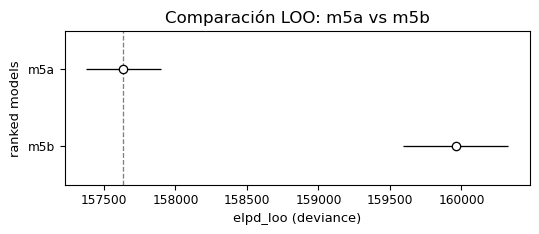

In [ ]:
# # ==============================
# # Comparación de modelos m5a vs m5b
# # --- 1) LOO individuales ---
# loo_m5a = az.loo(idata_m5a, pointwise=True)
# loo_m5b = az.loo(idata_m5b, pointwise=True)

# print("== LOO individuales ==")
# print("m5a:", loo_m5a)
# print("m5b:", loo_m5b)

# # --- 2) Comparación entre modelos (BB-pseudo-BMA sobre LOO) ---
# cmp_loo = az.compare(
#     {"m5a": idata_m5a, "m5b": idata_m5b},
#     method="BB-pseudo-BMA",
#     ic="loo",
#     scale="deviance"
# )
# print("\n== Comparación (LOO) ==")
# print(cmp_loo)

# # --- 3) Gráfico de comparación ---
# az.plot_compare(cmp_loo)
# plt.title("Comparación LOO: m5a vs m5b")
# plt.show()


Al imponer restricciones adicionales, el ajuste empeora, con predicciones no plausibles en municipios con pocos datos.

**Selección del modelo**

Se compararon los modelos m5a y m5b utilizando LOO (expected log predictive density). El modelo m5a obtuvo un elpd_loo ≈ –78,817, mientras que m5b alcanzó –79,979. Dado que valores menos negativos indican mejor capacidad predictiva, m5a muestra un ajuste superior. 

La diferencia en desempeño fue de aproximadamente 2,324 puntos a favor de m5a, con un error estándar cercano a 300. Esto significa que la ventaja de m5a es estadísticamente robusta y no atribuible al azar. 

Además, m5a es más parsimonioso (p_loo ≈ 316 vs 347 en m5b), lo que implica menor complejidad efectiva del modelo. Ambos modelos presentaron diagnósticos de Pareto k adecuados (100% en rango <0.7), por lo que las métricas son confiables. 

En resumen, m5a es el modelo claramente superior: predice mejor, es más simple y sus verificaciones PPC son plausibles. Por estas razones, se adopta m5a como modelo final para el análisis.


---

## Trasladando el modelo 5a a un modelo de percentiles estilo LMS 

**Por qué convertir el modelo a percentiles “compatibles con CDC (LMS)”**

Nuestro modelo m5a ya aprende talla según edad y sexo (y variación por municipio). Para comparar con tablas clínicas como las de CDC necesitamos expresar los resultados como percentiles por edad y sexo, y opcionalmente en el formato LMS (Lambda–Mu–Sigma). Eso permite calcular z-scores y superponer curvas como en los “growth charts”.

**Qué significa “compatible con CDC (LMS)”**
- Para cada edad y sexo queremos: p3, p10, p25, p50 (mediana), p75, p90, p97.
- LMS resume la distribución con tres curvas por edad:
  - L (lambda): controla asimetría.
  - M (mu): mediana.
  - S (sigma): dispersión relativa.
- Con L, M y S puedes calcular z-scores y percentiles con fórmulas simples.

**Fórmulas en texto plano**
- z-score cuando L ≠ 0:
  z = ((y / M)^L − 1) / (L * S)
- z-score cuando L = 0:
  z = ln(y / M) / S

**Por qué no basta con el modelo tal cual**
- m5a entrega distribuciones predictivas, no tablas de percentiles listas.
- Las tablas CDC se publican como percentiles por edad/sexo; para comparar “manzanas con manzanas” debemos convertir nuestras predicciones a ese formato.

**Qué haremos exactamente**
1. Definir una malla de edades en la misma escala que usamos al entrenar (por ejemplo, edad centrada).
2. Reconstruir la media por edad con los parámetros del modelo y simular la posterior predictiva (incluye la variabilidad residual).
3. Calcular percentiles por edad y sexo a partir de esas simulaciones.
4. (Opcional) Ajustar L, M, S por edad para que reproduzcan bien varios percentiles; así obtenemos curvas L(edad), M(edad), S(edad).
5. Entregar un DataFrame con percentiles (y, si se quiere, con L, M, S) para graficar y comparar con CDC.

**Municipios: dos salidas útiles**
- Versión “CDC-like” (poblacional): fijamos efectos municipales a cero (a0 = 0, a1 = 0). Es la referencia directa y comparable con CDC.
- Versión “modelo completo”: marginalizamos la variación municipal (mezcla sobre municipios) para ver el impacto territorial en los percentiles. Útil para diagnóstico local.

**Ventajas de trabajar con percentiles/LMS**
- Interpretación clínica inmediata (percentiles y z-scores).
- Comparabilidad directa con las tablas CDC.
- Seguimos usando toda la inferencia bayesiana; solo cambiamos el formato de salida.

**Cautelas**
- Usar exactamente las mismas bases spline para predecir en la malla de edad que las usadas al entrenar.
- En municipios con pocos datos, los percentiles locales pueden ser más inestables; la versión “CDC-like” es la comparación oficial.
- Si ajustamos L y S por edad, es normal suavizar las curvas L(edad) y S(edad) para evitar ondulaciones pequeñas.

**Resumen**
- Convertimos m5a a percentiles (y opcionalmente a L, M, S) para hablar el mismo idioma que CDC.
- Publicamos dos productos: poblacional “CDC-like” y una versión con variación municipal marginalizada.
- Con esto podremos graficar, comparar y reportar resultados en el formato clínico estándar.



Cuando calculamos percentiles fijando a0=a1=0 (sin municipios) la curva poblacional se “caía” a edades altas. En el m5a parte de la tendencia con la edad quedó dentro de las pendientes municipales a1[j]. Si las anulamos, perdemos esa inclinación global. La solución que usamos ahora es sumar la **media poblacional** de los efectos municipales (promedio ponderado por tamaño del municipio): así recuperamos la inclinación y las curvas vuelven a ser crecientes y plausibles.

---

Paso 1 — Malla de edad y X_s_grid (mismas B-splines que en el entrenamiento)
Construimos una malla densa de edades en la misma escala que entrenamos (`df_model["edad_anios_calc"]`) y generamos `X_s_grid` aplicando **exactamente** la misma transformación de B-splines (mismos df, grado y nudos) que produjo `X_s`. Para garantizarlo, reutilizamos el `design_info` de `patsy`.


OK: X_s_grid coincide en columnas con X_s -> 5


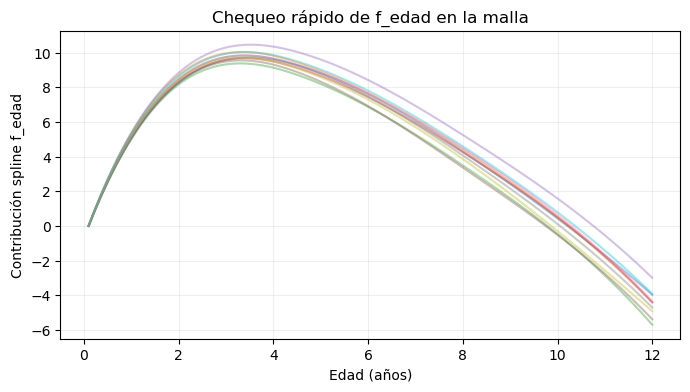

In [ ]:
# 1) Malla de edades en la MISMA escala usada al entrenar X_s (años crudos)
edad_min = float(df_model["edad_anios_calc"].min())
edad_max = float(df_model["edad_anios_calc"].max())
edad_grid = np.linspace(edad_min, edad_max, 121)  # ~ cada 0.1 año (~1.2 meses)

# 2) Asegurar X_spline para reutilizar sus nudos/estructura 
df_spline = 5  
X_spline = dmatrix(
    "bs(edad, df=df_spline, degree=3, include_intercept=False) - 1",
    {"edad": df_model["edad_anios_calc"].values},
    return_type="dataframe"
)

# 3) Construir X_s_grid con los MISMOS nudos y columnas
X_s_grid_df = build_design_matrices([X_spline.design_info], {"edad": edad_grid})[0]
X_s_grid = np.asarray(X_s_grid_df)

# 4) Chequeo de consistencia con la X_s usada en el modelo
assert X_s_grid.shape[1] == X_s.shape[1], \
    f"Columnas distintas: X_s={X_s.shape[1]}, X_s_grid={X_s_grid.shape[1]}"
print("OK: X_s_grid coincide en columnas con X_s ->", X_s_grid.shape[1])

# 5) Vista rápida de f_edad(edad) con algunas muestras (curvas deben ser suaves)
post = idata_m5a.posterior
def as_2d(da):  # (chain,draw,...) -> (sample,...)
    return da.stack(sample=("chain","draw")).transpose("sample", ...).values

w_s = as_2d(post["w_s"])            # (S, n_s)
f_grid = w_s @ X_s_grid.T           # (S, G)

rng = np.random.default_rng(42)
idx = rng.choice(w_s.shape[0], size=min(10, w_s.shape[0]), replace=False)
plt.figure(figsize=(8,4))
for i in idx:
    plt.plot(edad_grid, f_grid[i], alpha=0.4)
plt.xlabel("Edad (años)"); plt.ylabel("Contribución spline f_edad")
plt.title("Chequeo rápido de f_edad en la malla"); plt.grid(alpha=0.2)
plt.show()


Paso 2 — Percentiles “CDC-like” usando la media poblacional de los efectos municipales

En lugar de poner a0=a1=0, calculamos la media poblacional de los efectos municipales:
• a0_bar = promedio ponderado de a0[j] por tamaño del municipio  
• a1_bar = promedio ponderado de a1[j] por tamaño del municipio  
Luego construimos la media μ(edad, sexo) = términos globales + spline + interacción edad*sexo + a0_bar + a1_bar*edad_c.  
Simulamos una réplica posterior (Student-t) y extraemos percentiles p3, p10, p25, p50, p75, p90, p97 por edad y sexo.  
Esto recupera la inclinación global y deja las curvas crecientes, comparables con CDC.


In [ ]:

# Extraer parámetros necesarios del modelo
beta_0        = as_2d(post["beta_0"])          # (S,)
beta_sexo     = as_2d(post["beta_sexo"])       # (S,)
beta_edad_sex = as_2d(post["beta_edad_sex"])   # (S,)
nu_s          = as_2d(post["nu"])              # (S,)
sigma_s       = as_2d(post["sigma_obs"])       # (S,)
a0_s          = as_2d(post["a0"])              # (S, n_muni)
a1_s          = as_2d(post["a1"])              # (S, n_muni)

# Edad centrada EXACTAMENTE como en el entrenamiento
edad_mean_train = float(df_model["edad_anios_calc"].mean())
edad_c_grid = edad_grid - edad_mean_train      # (G,)

# Pesos por tamaño de municipio (frecuencia en datos)
uni_m, cnt_m = np.unique(muni_idx, return_counts=True)
w_m = cnt_m / cnt_m.sum()                      # (n_muni,)

# Medias poblacionales de efectos municipales (promedio posterior por muni, luego ponderado)
a0_hat_m = a0_s.mean(axis=0)                   # (n_muni,)
a1_hat_m = a1_s.mean(axis=0)                   # (n_muni,)
a0_bar   = float(np.sum(a0_hat_m * w_m))       # escalar
a1_bar   = float(np.sum(a1_hat_m * w_m))       # escalar
print(f"a0_bar={a0_bar:.3f}   a1_bar={a1_bar:.3f}")

# Percentiles objetivo
probs = np.array([0.03, 0.10, 0.25, 0.50, 0.75, 0.90, 0.97])
SEXO_LABELS = {0: "Mujer", 1: "Hombre"}  # 0 mujer, 1 hombre

def percentiles_cdc_like_con_media_muni(sexo_val: int) -> pd.DataFrame:
    """
    Percentiles poblacionales (CDC-like) por edad y sexo,
    agregando a0_bar + a1_bar*edad_c para conservar la inclinación media.
    """
    # Media μ sin municipalidades explícitas, pero con su media poblacional
    mu = (
        beta_0[:, None]
        + beta_sexo[:, None] * sexo_val
        + f_grid
        + beta_edad_sex[:, None] * (edad_c_grid[None, :] * sexo_val)
        + a0_bar
        + a1_bar * edad_c_grid[None, :]
    )                                           # (S, G)

    # 1 réplica posterior Student-t por muestra 
    y_rep = mu + sigma_s[:, None] * student_t.rvs(df=nu_s[:, None], size=mu.shape, random_state=42)

    # Percentiles a lo largo de muestras
    pct = np.quantile(y_rep, probs, axis=0).T  # (G, P)

    return pd.DataFrame({
        "edad_c": np.repeat(edad_c_grid, len(probs)),
        "percentil": np.tile(probs, len(edad_c_grid)),
        "talla": pct.ravel(),
        "sexo": int(sexo_val),
        "sexo_lbl": SEXO_LABELS[sexo_val],
    })

# Generar percentiles para 0=Mujer, 1=Hombre
pct_mujer  = percentiles_cdc_like_con_media_muni(0)
pct_hombre = percentiles_cdc_like_con_media_muni(1)
percentiles_cdc_like_df = pd.concat([pct_mujer, pct_hombre], ignore_index=True)

percentiles_cdc_like_df.head()


a0_bar=0.672   a1_bar=7.568


,edad_c,percentil,talla,sexo,sexo_lbl
0,-6.167597,0.03,49.977441,0,Mujer
1,-6.167597,0.10,53.583277,0,Mujer
2,-6.167597,0.25,56.887220,0,Mujer
3,-6.167597,0.50,60.206606,0,Mujer
4,-6.167597,0.75,63.626608,0,Mujer


Paso 3 — Tablas anchas (p3..p97) y gráficas tipo CDC
Convertimos a formato ancho para revisar p3, p50 y p97 por sexo y graficamos.  
Esperado: curvas suaves, ordenadas (p3 < p50 < p97) y **crecientes** con la edad.


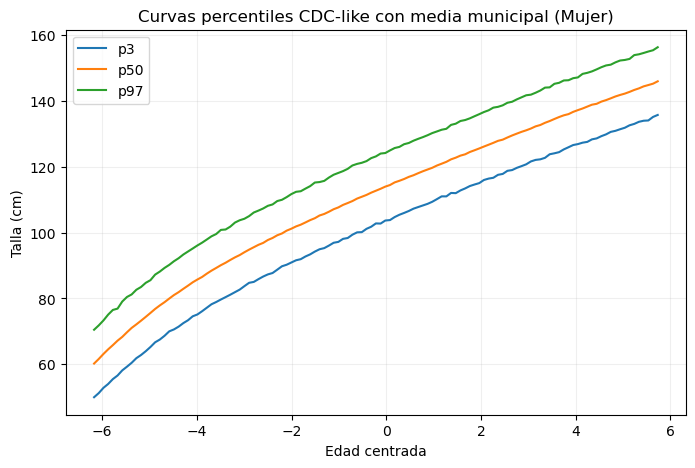

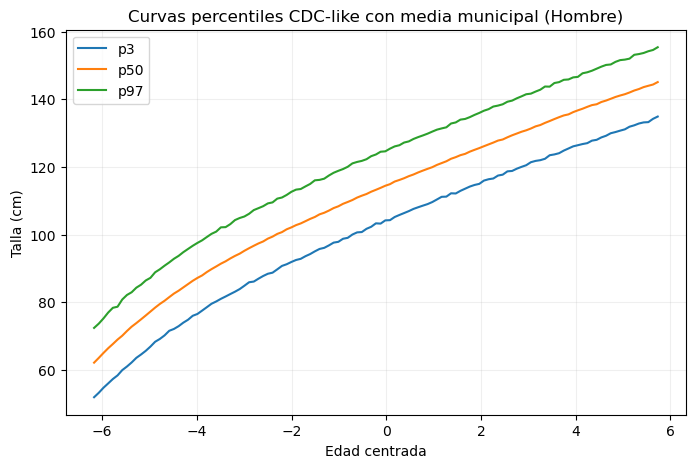

In [47]:
def tabla_percentiles(df_percentiles: pd.DataFrame, sexo_val: int) -> pd.DataFrame:
    return (
        df_percentiles.query(f"sexo=={sexo_val}")
        .pivot(index="edad_c", columns="percentil", values="talla")
        .rename(columns={0.03:"p3",0.10:"p10",0.25:"p25",0.50:"p50",0.75:"p75",0.90:"p90",0.97:"p97"})
        .sort_index()
        .reset_index()
    )

p_mujer  = tabla_percentiles(percentiles_cdc_like_df, 0)
p_hombre = tabla_percentiles(percentiles_cdc_like_df, 1)

def plot_p3_p50_p97(tabla: pd.DataFrame, titulo: str):
    plt.figure(figsize=(8,5))
    plt.plot(tabla["edad_c"], tabla["p3"],  label="p3")
    plt.plot(tabla["edad_c"], tabla["p50"], label="p50")
    plt.plot(tabla["edad_c"], tabla["p97"], label="p97")
    plt.title(titulo)
    plt.xlabel("Edad centrada")
    plt.ylabel("Talla (cm)")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

plot_p3_p50_p97(p_mujer,  "Curvas percentiles CDC-like con media municipal (Mujer)")
plot_p3_p50_p97(p_hombre, "Curvas percentiles CDC-like con media municipal (Hombre)")


In [50]:
# chequeo de forma: que las curvas sean crecientes con la edad y que los percentiles estén anidados (p3 < p50 < p97). si falla, en la siguiente celda lo corregimos

P_COLS = ["p3","p10","p25","p50","p75","p90","p97"]

def check_monotonia_y_anidamiento(tabla):
    diffs = np.diff(tabla[P_COLS].values, axis=0)
    ok_mono = np.all(diffs >= -1e-6)  # tolerancia numérica
    ok_nest = (tabla["p3"] <= tabla["p50"] + 1e-6).all() and (tabla["p50"] <= tabla["p97"] + 1e-6).all()
    return bool(ok_mono), bool(ok_nest)

ok_m_mono, ok_m_nest = check_monotonia_y_anidamiento(p_mujer)
ok_h_mono, ok_h_nest = check_monotonia_y_anidamiento(p_hombre)
print(f"Mujer  -> monotónica: {ok_m_mono} | anidada: {ok_m_nest}")
print(f"Hombre -> monotónica: {ok_h_mono} | anidada: {ok_h_nest}")


Mujer  -> monotónica: False | anidada: True
Hombre -> monotónica: False | anidada: True


In [ ]:
# si no son monotónicas, corregimos con regresión isotónica  o con mediana móvil + acumulado máximo
try:
    from sklearn.isotonic import IsotonicRegression
    HAS_ISO = True
except Exception:
    HAS_ISO = False

def monotone_by_age(tabla):
    t = tabla.sort_values("edad_c").reset_index(drop=True).copy()
    x = t["edad_c"].values
    for c in P_COLS:
        y = t[c].values.astype(float)
        if HAS_ISO:
            iso = IsotonicRegression(increasing=True, out_of_bounds="clip")
            y_hat = iso.fit_transform(x, y)
        else:
            y_s = pd.Series(y).rolling(3, min_periods=1, center=True).median().values
            y_hat = np.maximum.accumulate(y_s)
        t[c] = y_hat
    # re-anidar
    eps = 1e-6
    for j in range(1, len(P_COLS)):
        t[P_COLS[j]] = np.maximum(t[P_COLS[j]].values, t[P_COLS[j-1]].values + eps)
    return t

p_mujer_mon  = monotone_by_age(p_mujer)  if not ok_m_mono else p_mujer.copy()
p_hombre_mon = monotone_by_age(p_hombre) if not ok_h_mono else p_hombre.copy()

ok_m_mono2, ok_m_nest2 = check_monotonia_y_anidamiento(p_mujer_mon)
ok_h_mono2, ok_h_nest2 = check_monotonia_y_anidamiento(p_hombre_mon)
print(f"[Después] Mujer  -> monotónica: {ok_m_mono2} | anidada: {ok_m_nest2}")
print(f"[Después] Hombre -> monotónica: {ok_h_mono2} | anidada: {ok_h_nest2}")


[Después] Mujer  -> monotónica: True | anidada: True
[Después] Hombre -> monotónica: True | anidada: True


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/2700624808.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med = d.groupby(d["bin"].apply(lambda x: x.mid)).agg(mediana_obs=("talla","median")).reset_index().rename(columns={"bin":"centro"})
/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/2700624808.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med = d.groupby(d["bin"].apply(lambda x: x.mid)).agg(mediana_obs=("talla","median")).reset_index().rename(columns={"bin":"centro"})


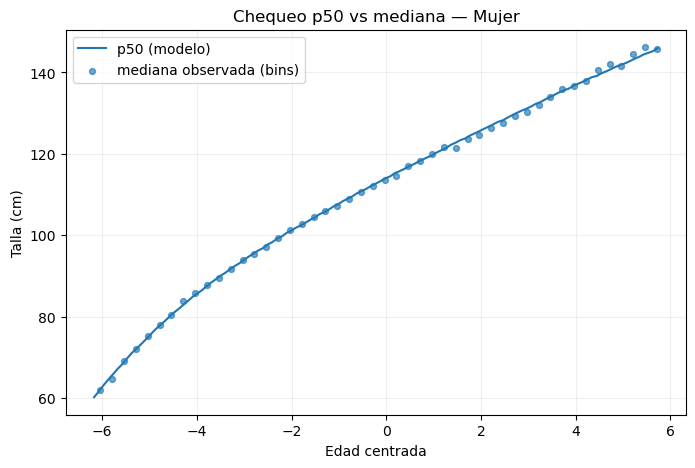

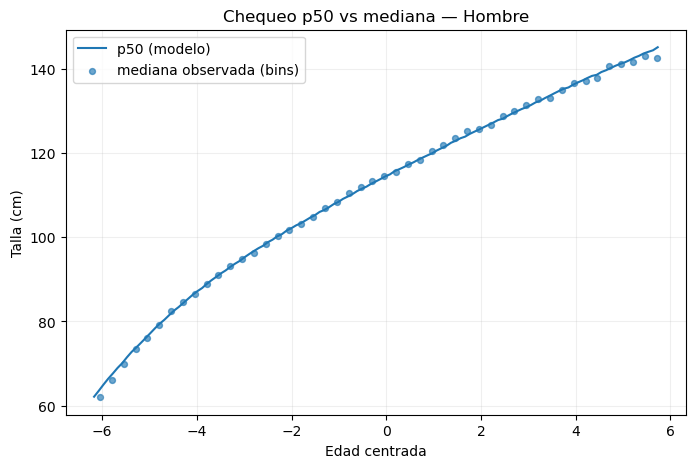

In [52]:
# chequeo rápido contra datos: p50 del modelo vs mediana observada por bins finos de edad. sirve para validar que la mediana está bien calibrada.

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

edad_mean_train = float(df_model["edad_anios_calc"].mean())
df_obs = pd.DataFrame({
    "edad_c": df_model["edad_anios_calc"].values - edad_mean_train,
    "talla":  df_model["talla_cm"].values,   # ajusta si tu columna difiere
    "sexo":   df_model["sexo"].values        # 0 mujer, 1 hombre
})

def resumen_por_sexo(sexo_val, tabla_pxx):
    d = df_obs[df_obs["sexo"]==sexo_val].copy()
    bin_w = 0.25
    bins = np.arange(d["edad_c"].min()-1e-9, d["edad_c"].max()+bin_w+1e-9, bin_w)
    d["bin"] = pd.cut(d["edad_c"], bins=bins, include_lowest=True)
    med = d.groupby(d["bin"].apply(lambda x: x.mid)).agg(mediana_obs=("talla","median")).reset_index().rename(columns={"bin":"centro"})
    p50_interp = np.interp(med["centro"].values, tabla_pxx["edad_c"].values, tabla_pxx["p50"].values)
    med["p50_modelo"] = p50_interp
    return med

med_m = resumen_por_sexo(0, p_mujer_mon)
med_h = resumen_por_sexo(1, p_hombre_mon)

def plot_p50_check(tabla, med, titulo):
    plt.figure(figsize=(8,5))
    plt.plot(tabla["edad_c"], tabla["p50"], label="p50 (modelo)")
    plt.scatter(med["centro"], med["mediana_obs"], s=18, alpha=0.65, label="mediana observada (bins)")
    plt.title(titulo); plt.xlabel("Edad centrada"); plt.ylabel("Talla (cm)")
    plt.legend(); plt.grid(alpha=0.2); plt.show()

plot_p50_check(p_mujer_mon,  med_m, "Chequeo p50 vs mediana — Mujer")
plot_p50_check(p_hombre_mon, med_h, "Chequeo p50 vs mediana — Hombre")


In [ ]:
# exporta tablas finales en edad real. estas son las curvas oficiales “CDC-like”
def add_edad_real(tabla):
    out = tabla.copy()
    out["edad_anios"] = out["edad_c"] + edad_mean_train
    return out[["edad_anios","edad_c"] + P_COLS]

p_mujer_y_mon  = add_edad_real(p_mujer_mon)
p_hombre_y_mon = add_edad_real(p_hombre_mon)

p_mujer_y_mon.to_csv("percentiles_cdc_like_m5a_mujer.csv", index=False)
p_hombre_y_mon.to_csv("percentiles_cdc_like_m5a_hombre.csv", index=False)
print("CSV guardados: percentiles_cdc_like_m5a_mujer.csv / ..._hombre.csv")


CSV guardados: percentiles_cdc_like_m5a_mujer.csv / ..._hombre.csv


In [ ]:
from scipy.interpolate import interp1d
import numpy as np

# --- Función: crea interpoladores lineales de las curvas de percentiles ---
def interp_curvas(tabla):
    # Regresa un diccionario con funciones f(edad_c) para p3, p50 y p97
    return {
        c: interp1d(
            tabla["edad_c"],    # eje x: edad centrada
            tabla[c],           # eje y: valores del percentil
            kind="linear", 
            fill_value="extrapolate"  # extrapola fuera del rango
        )
        for c in ["p3","p50","p97"]
    }

# Interpoladores para mujer y hombre
f_m, f_h = interp_curvas(p_mujer), interp_curvas(p_hombre)

# --- Datos observados ---
edad_mean_train = float(df_model["edad_anios_calc"].mean())  # media de edad (para centrar)
edad_c_obs = df_model["edad_anios_calc"].values - edad_mean_train  # edad centrada
y_obs      = df_model["talla_cm"].values   # talla observada
sexo_obs   = df_model["sexo"].values       # 0 = mujer, 1 = hombre

# --- Máscaras por sexo ---
is_m, is_h = (sexo_obs==0), (sexo_obs==1)

# --- Chequeo de calibración ---
# proporción de observaciones <= p50 esperado
p50_m = np.mean(y_obs[is_m] <= f_m["p50"](edad_c_obs[is_m]))
p50_h = np.mean(y_obs[is_h] <= f_h["p50"](edad_c_obs[is_h]))

# cobertura dentro del intervalo [p3, p97]
cov_m = np.mean((y_obs[is_m] >= f_m["p3"](edad_c_obs[is_m])) &
                (y_obs[is_m] <= f_m["p97"](edad_c_obs[is_m])))

cov_h = np.mean((y_obs[is_h] >= f_h["p3"](edad_c_obs[is_h])) &
                (y_obs[is_h] <= f_h["p97"](edad_c_obs[is_h])))

# --- Resultados ---
print(f"Mujer  p50={p50_m:.3f}  p3–p97={cov_m:.3f}")
print(f"Hombre p50={p50_h:.3f}  p3–p97={cov_h:.3f}")


Mujer  p50=0.499  p3–p97=0.931
Hombre p50=0.504  p3–p97=0.936


In [ ]:
from scipy.stats import norm
from scipy.optimize import least_squares
import pandas as pd
import numpy as np

# Probabilidades (percentiles) que vamos a ajustar: 3%, 10%, 25%, 75%, 90%, 97%
probs_fit = np.array([0.03, 0.10, 0.25, 0.75, 0.90, 0.97])

def fit_LS_given_quantiles(qs, ps, M):
    """
    Ajusta (L, S) del modelo LMS a partir de cuantiles conocidos (qs) y sus probabilidades (ps),
    manteniendo M fijo (la mediana = p50).
    - qs: array de cuantiles observados (en cm) para ps
    - ps: probabilidades asociadas a qs (en [0,1])
    - M : mediana (p50) en cm, fija
    Retorna: (L, S)
    """
    z = norm.ppf(ps)  # z-scores correspondientes a los percentiles ps

    # Modelo de cuantiles del LMS (Box-Cox):
    # Q(p) = M * (1 + L*S*z)^(1/L)   si L != 0
    # Q(p) = M * exp(S*z)            si L  ~ 0   (límite log-normal)
    def model_q(L, S):
        if abs(L) < 1e-6:  # caso límite L≈0 → lognormal
            return M * np.exp(S * z)
        return M * np.power(1 + L * S * z, 1.0 / L)

    # Residuos a minimizar (escala relativa para no sobreponderar cuantiles grandes)
    def resid(theta):
        L, S = theta
        return (model_q(L, S) - qs) / np.maximum(1.0, qs)

    # Ajuste por mínimos cuadrados con cotas razonables:
    # L en [-2, 2], S en [1e-6, 5] (S>0)
    sol = least_squares(
        resid,
        x0=[0.1, 0.1],                   # inicialización suave
        bounds=([-2.0, 1e-6], [2.0, 5.0])
    )
    return float(sol.x[0]), float(sol.x[1])

def lms_desde_tabla(tabla_pxx, sexo_val):
    """
    Estima L y S por edad centrada usando como M la mediana p50 de la tabla.
    Devuelve un DataFrame con columnas: sexo, edad_c, edad_anios, L, M, S.
    """
    rows = []
    for _, r in tabla_pxx.sort_values("edad_c").iterrows():
        M  = float(r["p50"])  # M (mediana) fijada en p50
        qs = np.array([r["p3"], r["p10"], r["p25"], r["p75"], r["p90"], r["p97"]], dtype=float)
        L, S = fit_LS_given_quantiles(qs, probs_fit, M)
        rows.append({
            "sexo": sexo_val,
            "edad_c": r["edad_c"],
            "edad_anios": r["edad_c"] + edad_mean_train,  # descentrar para reporte
            "L": L, "M": M, "S": S
        })
    return pd.DataFrame(rows)

# Estimar curvas LMS por sexo a partir de percentiles suavizados (p_mujer / p_hombre)
lms_mujer  = lms_desde_tabla(p_mujer,  0)
lms_hombre = lms_desde_tabla(p_hombre, 1)

# Unir y guardar
lms_all = pd.concat([lms_mujer, lms_hombre], ignore_index=True)
lms_all.to_csv("lms_m5a.csv", index=False)
print("Guardado: lms_m5a.csv")


Guardado: lms_m5a.csv


In [59]:
import numpy as np, pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm

# --- Cargar parámetros LMS desde CSV ---
#  (con columnas sexo, edad_anios, L, M, S)
lms_all = pd.read_csv("lms_m5a.csv")

# --- Construir interpoladores lineales de L, M y S por sexo ---
def build_lms_interps(lms_df):
    f = {}
    for sexo in (0, 1):  # 0 = mujer, 1 = hombre
        # Filtrar por sexo y ordenar por edad
        sub = (lms_df[lms_df["sexo"] == sexo]
               .sort_values("edad_anios")
               .reset_index(drop=True))
        if sub.empty:
            continue  # si no hay datos, lo salta

        # Crear funciones de interpolación L(edad), M(edad), S(edad)
        f[sexo] = {
            "L": interp1d(sub["edad_anios"], sub["L"], kind="linear", fill_value="extrapolate"),
            "M": interp1d(sub["edad_anios"], sub["M"], kind="linear", fill_value="extrapolate"),
            "S": interp1d(sub["edad_anios"], sub["S"], kind="linear", fill_value="extrapolate"),
        }
    return f

# Diccionario global: F_LMS[sexo]["L/M/S"](edad_anios)
F_LMS = build_lms_interps(lms_all)

# --- Fórmulas del método LMS ---
def z_from_LMS(y, L, M, S):
    """
    Convierte una talla (y) en z-score dado L, M, S.
    - L: parámetro de asimetría (Box-Cox)
    - M: mediana (p50)
    - S: coeficiente de variación
    Caso especial: L≈0 -> distribución lognormal.
    """
    if abs(L) < 1e-6:
        return np.log(y / M) / S
    return ((y / M)**L - 1) / (L * S)

def y_from_LMS(z, L, M, S):
    """
    Convierte un z-score en talla (y) dado L, M, S.
    Inversa de z_from_LMS.
    """
    if abs(L) < 1e-6:
        return M * np.exp(S * z)
    return M * (1 + L * S * z)**(1 / L)

# --- Funciones de consulta para cualquier edad y sexo ---
def zscore(edad_anios, sexo, talla_cm):
    """
    Devuelve el z-score de un niño(a) dado edad, sexo y talla en cm.
    Interpola L, M, S para la edad especificada.
    """
    L = np.asarray(F_LMS[sexo]["L"](edad_anios), dtype=float)
    M = np.asarray(F_LMS[sexo]["M"](edad_anios), dtype=float)
    S = np.asarray(F_LMS[sexo]["S"](edad_anios), dtype=float)
    return z_from_LMS(talla_cm, L, M, S)

def percentil(edad_anios, sexo, talla_cm):
    """
    Devuelve el percentil (entre 0 y 1) de la talla observada.
    Calcula el z-score y luego lo pasa por la cdf normal.
    """
    return norm.cdf(zscore(edad_anios, sexo, talla_cm))

def talla_en_percentil(edad_anios, sexo, p):
    """
    Devuelve la talla (cm) correspondiente al percentil p (ej. 0.5 = mediana).
    """
    z = norm.ppf(p)  # convierte percentil en z-score
    L = np.asarray(F_LMS[sexo]["L"](edad_anios), dtype=float)
    M = np.asarray(F_LMS[sexo]["M"](edad_anios), dtype=float)
    S = np.asarray(F_LMS[sexo]["S"](edad_anios), dtype=float)
    return y_from_LMS(z, L, M, S)

# --- Pruebas rápidas ---
print("z Mujer(6.0 años, 120 cm):", float(zscore(6.0, 0, 120)))
print("p Mujer(6.0 años, 120 cm):", float(percentil(6.0, 0, 120)))
print("p50 Hombre a 6.0 años:",    float(talla_en_percentil(6.0, 1, 0.5)))


z Mujer(6.0 años, 120 cm): 1.4108307363574997
p Mujer(6.0 años, 120 cm): 0.9208527354021006
p50 Hombre a 6.0 años: 112.97096541214736


Este chunk implementa de forma funcional el método **LMS** para curvas de crecimiento. Primero carga los parámetros `L`, `M` y `S` por edad y sexo desde un archivo CSV, y construye interpoladores lineales para poder estimar estos valores en cualquier edad. Con ello, define funciones que permiten: calcular el **z-score** de una talla dada (`zscore`), convertir ese z-score en un **percentil** (`percentil`), o bien obtener la talla esperada en un **percentil específico** (`talla_en_percentil`). De esta manera, el código facilita comparar observaciones individuales contra las referencias de crecimiento ajustadas por edad y sexo.


In [60]:
from scipy.interpolate import interp1d
import numpy as np

# --- Función para construir interpoladores de percentiles ---
def interp_curvas(tabla):
    # Crea funciones de interpolación para p3, p50 y p97 a lo largo de la edad centrada
    return {
        c: interp1d(
            tabla["edad_c"],     # eje x = edad centrada
            tabla[c],            # eje y = percentil correspondiente
            kind="linear", 
            fill_value="extrapolate"  # permite extrapolar fuera del rango observado
        )
        for c in ["p3", "p50", "p97"]
    }

# Interpoladores para mujeres y hombres a partir de tablas de percentiles
f_m, f_h = interp_curvas(p_mujer_mon), interp_curvas(p_hombre_mon)

# --- Preparar datos observados ---
edad_mean_train = float(df_model["edad_anios_calc"].mean())  # media de edad para centrar
edad_c_obs = df_model["edad_anios_calc"].values - edad_mean_train  # edad centrada de cada obs
y_obs      = df_model["talla_cm"].values   # tallas observadas
sexo_obs   = df_model["sexo"].values       # sexo: 0 = mujer, 1 = hombre

# --- Máscaras por sexo ---
is_m, is_h = (sexo_obs == 0), (sexo_obs == 1)

# --- Chequeo de calibración ---
# Proporción de niñas cuya talla ≤ p50 esperado
p50_m = np.mean(y_obs[is_m] <= f_m["p50"](edad_c_obs[is_m]))
# Proporción de niños cuya talla ≤ p50 esperado
p50_h = np.mean(y_obs[is_h] <= f_h["p50"](edad_c_obs[is_h]))

# Cobertura de tallas dentro del intervalo [p3, p97]
cov_m = np.mean((y_obs[is_m] >= f_m["p3"](edad_c_obs[is_m])) &
                (y_obs[is_m] <= f_m["p97"](edad_c_obs[is_m])))
cov_h = np.mean((y_obs[is_h] >= f_h["p3"](edad_c_obs[is_h])) &
                (y_obs[is_h] <= f_h["p97"](edad_c_obs[is_h])))

# --- Resultados ---
print(f"Mujer  p50={p50_m:.3f}  p3–p97={cov_m:.3f}")
print(f"Hombre p50={p50_h:.3f}  p3–p97={cov_h:.3f}")


Mujer  p50=0.499  p3–p97=0.931
Hombre p50=0.504  p3–p97=0.936


Este chunk evalúa la **calibración de las curvas de percentiles de talla**. Primero construye funciones de interpolación lineal para los percentiles 3, 50 y 97 (p3, p50, p97) a partir de las tablas de referencia por sexo. Luego centra la edad observada de cada niño o niña y compara sus tallas contra las curvas interpoladas. Con ello calcula dos métricas clave: (1) la proporción de observaciones que caen por debajo del percentil 50 esperado (idealmente cercana a 0.5 si el modelo está bien calibrado) y (2) la proporción que se encuentra dentro del rango [p3, p97] (idealmente cercana a 0.94). Finalmente imprime estos valores por sexo, lo que permite verificar si las curvas ajustadas representan adecuadamente la distribución de los datos observados.
